In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import cv2
from keras.models import load_model,Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,Dropout,Flatten,AveragePooling2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras.backend import set_session,clear_session,get_session
import gc

# 輸出圖片
def show_images_labels_predictions(images,labels,predictions,start_id,num=10):
  plt.gcf().set_size_inches(12,14)
  if num>25: num=25
  for i in range(0,num):
    ax=plt.subplot(5,5,1+i) # 畫圖但用子圖呈現
    ax.imshow(images[start_id][:,:,[2,1,0]])
    if(len(predictions)>0):
      title='ai='+str(predictions[start_id])
      title+=('(o)' if predictions[start_id]==labels[start_id] else '(x)')
      title+='\nlabel='+str(labels[start_id])
    else:
      title='label='+str(labels[start_id])
    ax.set_title(title,fontsize=12)
    ax.set_xticks([]);ax.set_yticks([])
    start_id+=1
  plt.show()
    
# 重置keras
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
np.random.seed(1)

# 可視化卷積後的圖片
def plot_feature_maps(feature_maps):
    num_features = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        feature_map = feature_maps[0, :, :, i]
        feature_map -= feature_map.mean()
        feature_map /= feature_map.std()
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = feature_map

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# 讀取圖片,共七種類別
def data_preprocessing(cat_files, dog_files, wild_1, wild_2, wild_3, wild_4, wild_5):
    
    # 串列表達式並用cv2讀取並縮放圖片
    cat = [cv2.resize(cv2.imread(i), (128, 128)) for i in cat_files]
    dog = [cv2.resize(cv2.imread(i), (128,128)) for i in dog_files]
    fox = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_1]
    leopard = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_2]
    lion = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_3]
    tiger = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_4]
    wolf = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_5]
    
    cat = np.array(cat)
    dog = np.array(dog)
    fox = np.array(fox)
    leopard = np.array(leopard)
    lion = np.array(lion)
    tiger = np.array(tiger)
    wolf = np.array(wolf)

    # 定義一個陣列用來存放label,貓的label=0,狗的label=1,狐的label=2,豹的label=3,獅的label=4,虎的label=5,狼的label=6
    label = []
    for i in cat:
        label.append(0)
    for i in dog:
        label.append(1)
    for i in fox:
        label.append(2)
    for i in leopard:
        label.append(3)
    for i in lion:
        label.append(4)
    for i in tiger:
        label.append(5)
    for i in wolf:
        label.append(6)
        
    # 把前面分開讀取的圖片和為一個陣列,並做標準化處理
    feature = np.concatenate((cat, dog, fox, leopard, lion, tiger, wolf))
    feature = (feature.astype("float32") / 255)
    
    # 標籤做one-hot encoding
    label = np.array(label)
    print("貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6\n各類別樣本數:\n",pd.Series(label).value_counts())
    label = np_utils.to_categorical(label)

    return feature,label

# 使用未增強資料

## 訓練

In [2]:
cat = glob.glob("./train/cat/*.jpg")
dog = glob.glob("./train/dog/*.jpg")
fox = glob.glob("./train/fox/*.jpg")
leopard = glob.glob("./train/leopard/*.jpg")
lion = glob.glob("./train/lion/*.jpg")
tiger = glob.glob("./train/tiger/*.jpg")
wolf = glob.glob("./train/wolf/*.jpg")

In [3]:
feature,label = data_preprocessing(cat, dog, fox, leopard, lion, tiger, wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 0    5603
1    5189
3    1670
4    1330
5    1120
2     433
6     411
Name: count, dtype: int64


In [4]:
train_feature, test_feature, train_label, test_label = train_test_split(feature, label, test_size=0.1, random_state=40)
print(train_feature.shape, test_feature.shape, train_label.shape, test_label.shape)

(14180, 128, 128, 3) (1576, 128, 128, 3) (14180, 7) (1576, 7)


43


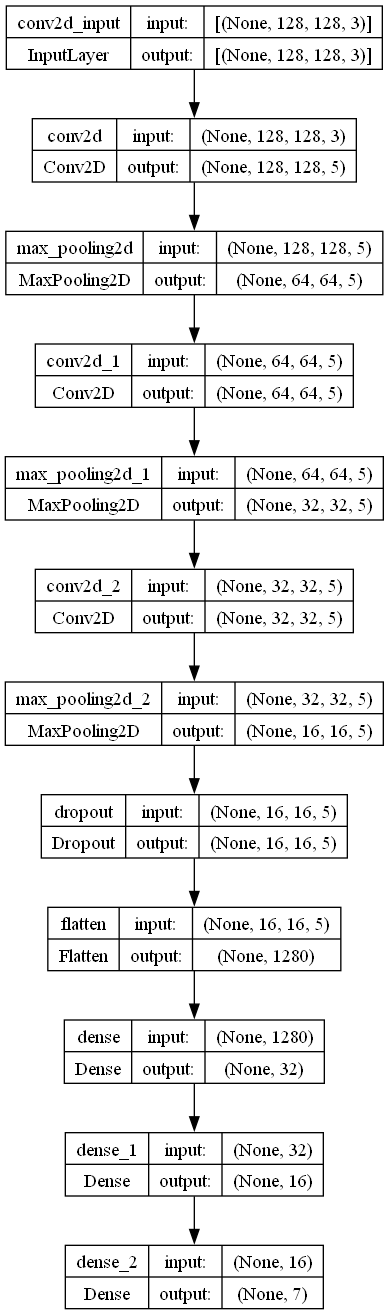

In [5]:
np.random.seed(1)
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.45))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dense(units=7, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(model_CNN,show_shapes=True)

In [6]:
train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=128,verbose=1)

Epoch 1/30
100/100 [==============================] - 8s 29ms/step - loss: 1.4706 - accuracy: 0.4428 - val_loss: 1.0750 - val_accuracy: 0.6227
Epoch 2/30
100/100 [==============================] - 2s 24ms/step - loss: 0.9967 - accuracy: 0.6510 - val_loss: 0.6919 - val_accuracy: 0.7786
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.7023 - accuracy: 0.7568 - val_loss: 0.5183 - val_accuracy: 0.8202
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 0.5609 - accuracy: 0.8087 - val_loss: 0.4342 - val_accuracy: 0.8618
Epoch 5/30
100/100 [==============================] - 2s 23ms/step - loss: 0.4665 - accuracy: 0.8468 - val_loss: 0.3384 - val_accuracy: 0.8836
Epoch 6/30
100/100 [==============================] - 2s 23ms/step - loss: 0.4295 - accuracy: 0.8549 - val_loss: 0.3168 - val_accuracy: 0.8977
Epoch 7/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3761 - accuracy: 0.8746 - val_loss: 0.3320 - val_accuracy: 0.8829

In [8]:
score = model_CNN.evaluate(test_feature, test_label)
print(score)

50/50 [==============================] - 0s 5ms/step - loss: 0.2434 - accuracy: 0.9201
[0.2434026449918747, 0.9200507402420044]


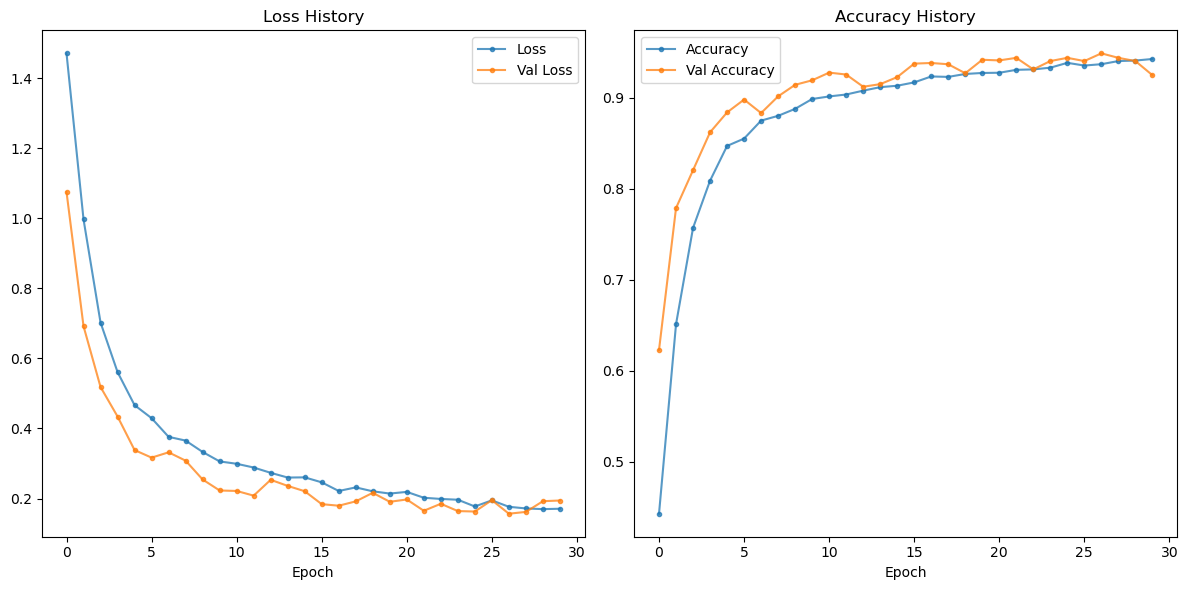

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Loss History")
ax1.plot(train_history.history['loss'], marker='.', alpha=0.75, label='Loss')
ax1.plot(train_history.history['val_loss'], marker='.', alpha=0.75, label='Val Loss')
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.set_title("Accuracy History")
ax2.plot(train_history.history['accuracy'], marker='.', alpha=0.75, label='Accuracy')
ax2.plot(train_history.history['val_accuracy'], marker='.', alpha=0.75, label='Val Accuracy')
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

## 驗證

In [10]:
val_cat = glob.glob("./val/cat/*.jpg")
val_dog = glob.glob("./val/dog/*.jpg")
val_fox = glob.glob("./val/fox/*.jpg")
val_leopard = glob.glob("./val/leopard/*.jpg")
val_lion = glob.glob("./val/lion/*.jpg")
val_tiger = glob.glob("./val/tiger/*.jpg")
val_wolf = glob.glob("./val/wolf/*.jpg")
val_feature, val_label = data_preprocessing(val_cat, val_dog, val_fox, val_leopard, val_lion, val_tiger, val_wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 0    50
1    50
2    50
3    50
4    50
5    50
6    50
Name: count, dtype: int64


In [11]:
reset_keras()
val_pre=model_CNN.predict(val_feature)
val_score=model_CNN.evaluate(val_feature,val_label)
print(val_score)

3137
11/11 [==============================] - 0s 4ms/step - loss: 0.2710 - accuracy: 0.9029
[0.270995557308197, 0.9028571248054504]


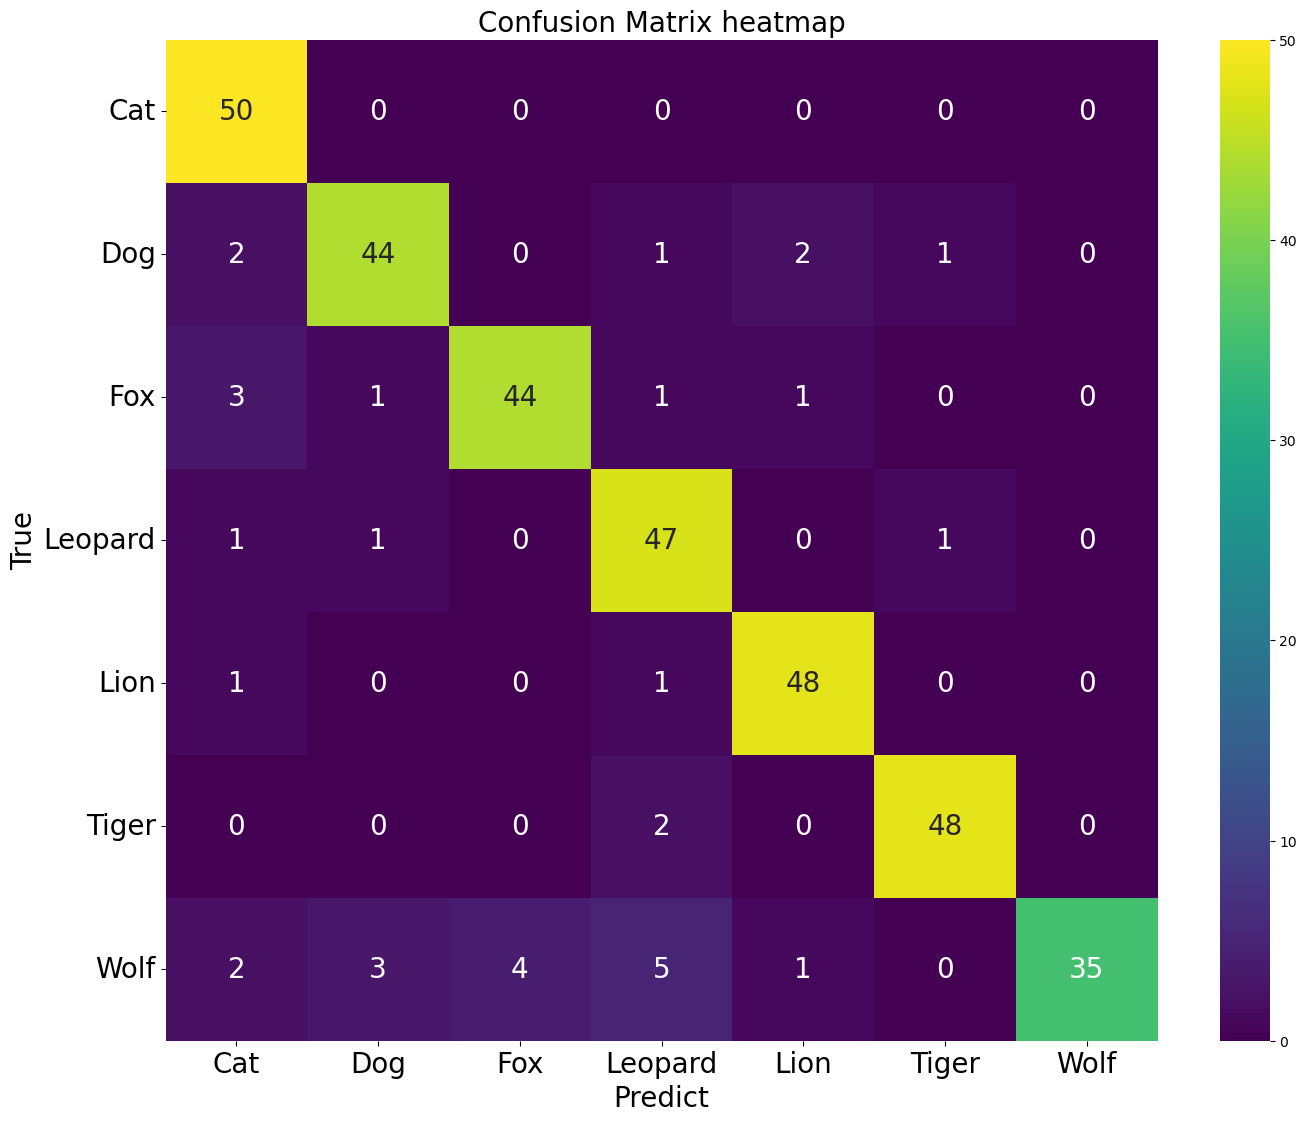

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
訓練集各類別樣本數:
 0    5085
1    4662
3    1479
4    1218
5     978
2     391
6     367
Name: count, dtype: int64


In [12]:
# 貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
heatmap_label=["Cat","Dog","Fox","Leopard","Lion","Tiger","Wolf"]
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 20, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True",fontsize=20)
heatmap.set_xticklabels(heatmap_label, fontsize=20)
plt.xlabel("Predict",fontsize=20)
heatmap.set_yticklabels(heatmap_label, rotation=0, fontsize=20)
plt.title("Confusion Matrix heatmap",fontsize=20)
plt.show()
print("貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6\n訓練集各類別樣本數:\n",pd.Series(np.argmax(train_label, axis=1)).value_counts())

# 使用增強過的資料

## 訓練

In [13]:
cat = glob.glob("./train/cat/*.[jp][pn]g")
dog = glob.glob("./train/dog/*.[jp][pn]g")
fox = glob.glob("./train/fox/*.[jp][pn]g")
leopard = glob.glob("./train/leopard/*.[jp][pn]g")
lion = glob.glob("./train/lion/*.[jp][pn]g")
tiger = glob.glob("./train/tiger/*.[jp][pn]g")
wolf = glob.glob("./train/wolf/*.[jp][pn]g")

In [14]:
feature,label = data_preprocessing(cat, dog, fox, leopard, lion, tiger, wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 3    6150
0    5603
1    5189
4    4868
5    4077
6    4074
2    3948
Name: count, dtype: int64


In [15]:
train_feature, test_feature, train_label, test_label = train_test_split(feature, label, test_size=0.1, random_state=40)
print(train_feature.shape, test_feature.shape, train_label.shape, test_label.shape)

(30518, 128, 128, 3) (3391, 128, 128, 3) (30518, 7) (3391, 7)


72


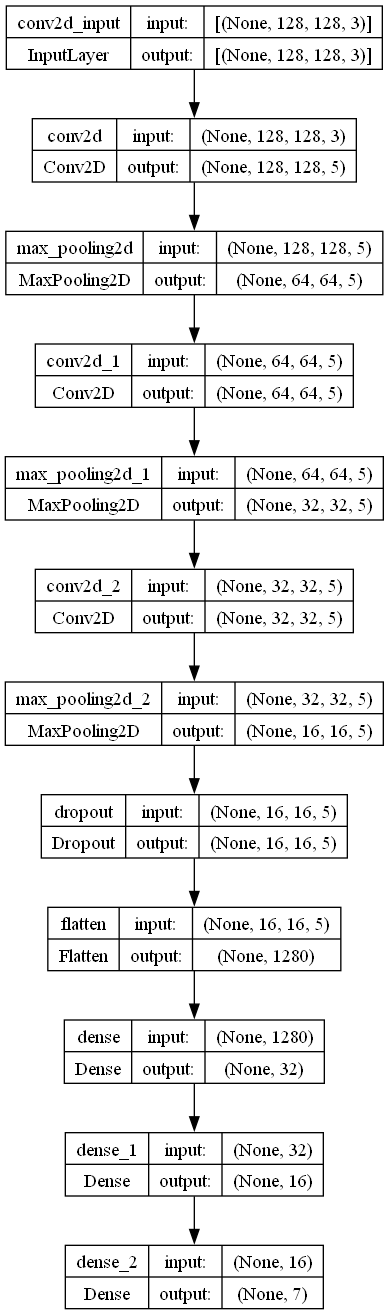

In [16]:
np.random.seed(1)
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.45))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dense(units=7, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(model_CNN,show_shapes=True)

In [17]:
train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=128,verbose=1)

Epoch 1/30
215/215 [==============================] - 6s 25ms/step - loss: 1.3756 - accuracy: 0.4826 - val_loss: 0.8260 - val_accuracy: 0.7172
Epoch 2/30
215/215 [==============================] - 5s 23ms/step - loss: 0.7672 - accuracy: 0.7260 - val_loss: 0.5759 - val_accuracy: 0.7952
Epoch 3/30
215/215 [==============================] - 5s 23ms/step - loss: 0.6065 - accuracy: 0.7897 - val_loss: 0.4275 - val_accuracy: 0.8535
Epoch 4/30
215/215 [==============================] - 5s 22ms/step - loss: 0.5018 - accuracy: 0.8268 - val_loss: 0.3506 - val_accuracy: 0.8863
Epoch 5/30
215/215 [==============================] - 5s 22ms/step - loss: 0.4412 - accuracy: 0.8484 - val_loss: 0.3369 - val_accuracy: 0.8863
Epoch 6/30
215/215 [==============================] - 5s 22ms/step - loss: 0.4047 - accuracy: 0.8601 - val_loss: 0.3093 - val_accuracy: 0.9001
Epoch 7/30
215/215 [==============================] - 5s 22ms/step - loss: 0.3667 - accuracy: 0.8722 - val_loss: 0.2713 - val_accuracy: 0.9050

In [18]:
score = model_CNN.evaluate(test_feature, test_label)
print(score)

106/106 [==============================] - 0s 4ms/step - loss: 0.1659 - accuracy: 0.9475
[0.16592706739902496, 0.9475080966949463]


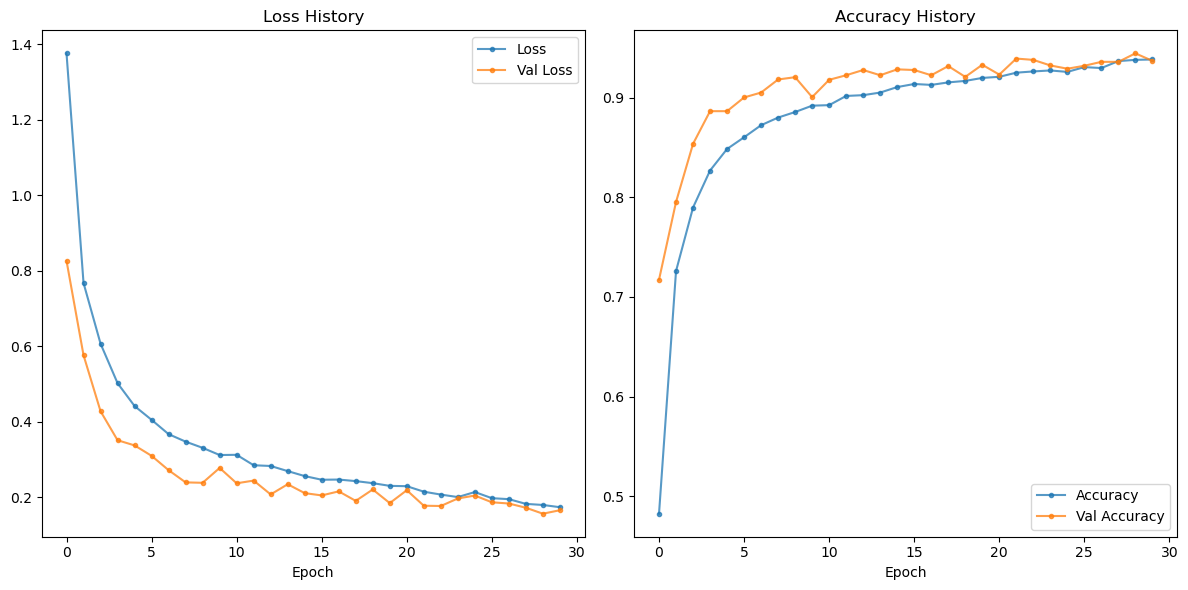

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_title("Loss History")
ax1.plot(train_history.history['loss'], marker='.', alpha=0.75, label='Loss')
ax1.plot(train_history.history['val_loss'], marker='.', alpha=0.75, label='Val Loss')
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.set_title("Accuracy History")
ax2.plot(train_history.history['accuracy'], marker='.', alpha=0.75, label='Accuracy')
ax2.plot(train_history.history['val_accuracy'], marker='.', alpha=0.75, label='Val Accuracy')
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

## 驗證

In [20]:
val_cat = glob.glob("./val/cat/*.jpg")
val_dog = glob.glob("./val/dog/*.jpg")
val_fox = glob.glob("./val/fox/*.jpg")
val_leopard = glob.glob("./val/leopard/*.jpg")
val_lion = glob.glob("./val/lion/*.jpg")
val_tiger = glob.glob("./val/tiger/*.jpg")
val_wolf = glob.glob("./val/wolf/*.jpg")
val_feature, val_label = data_preprocessing(val_cat, val_dog, val_fox, val_leopard, val_lion, val_tiger, val_wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 0    50
1    50
2    50
3    50
4    50
5    50
6    50
Name: count, dtype: int64


In [21]:
reset_keras()
val_pre=model_CNN.predict(val_feature)
val_score=model_CNN.evaluate(val_feature,val_label)
print(val_score)

14290
11/11 [==============================] - 0s 4ms/step - loss: 0.1790 - accuracy: 0.9429
[0.17904438078403473, 0.9428571462631226]


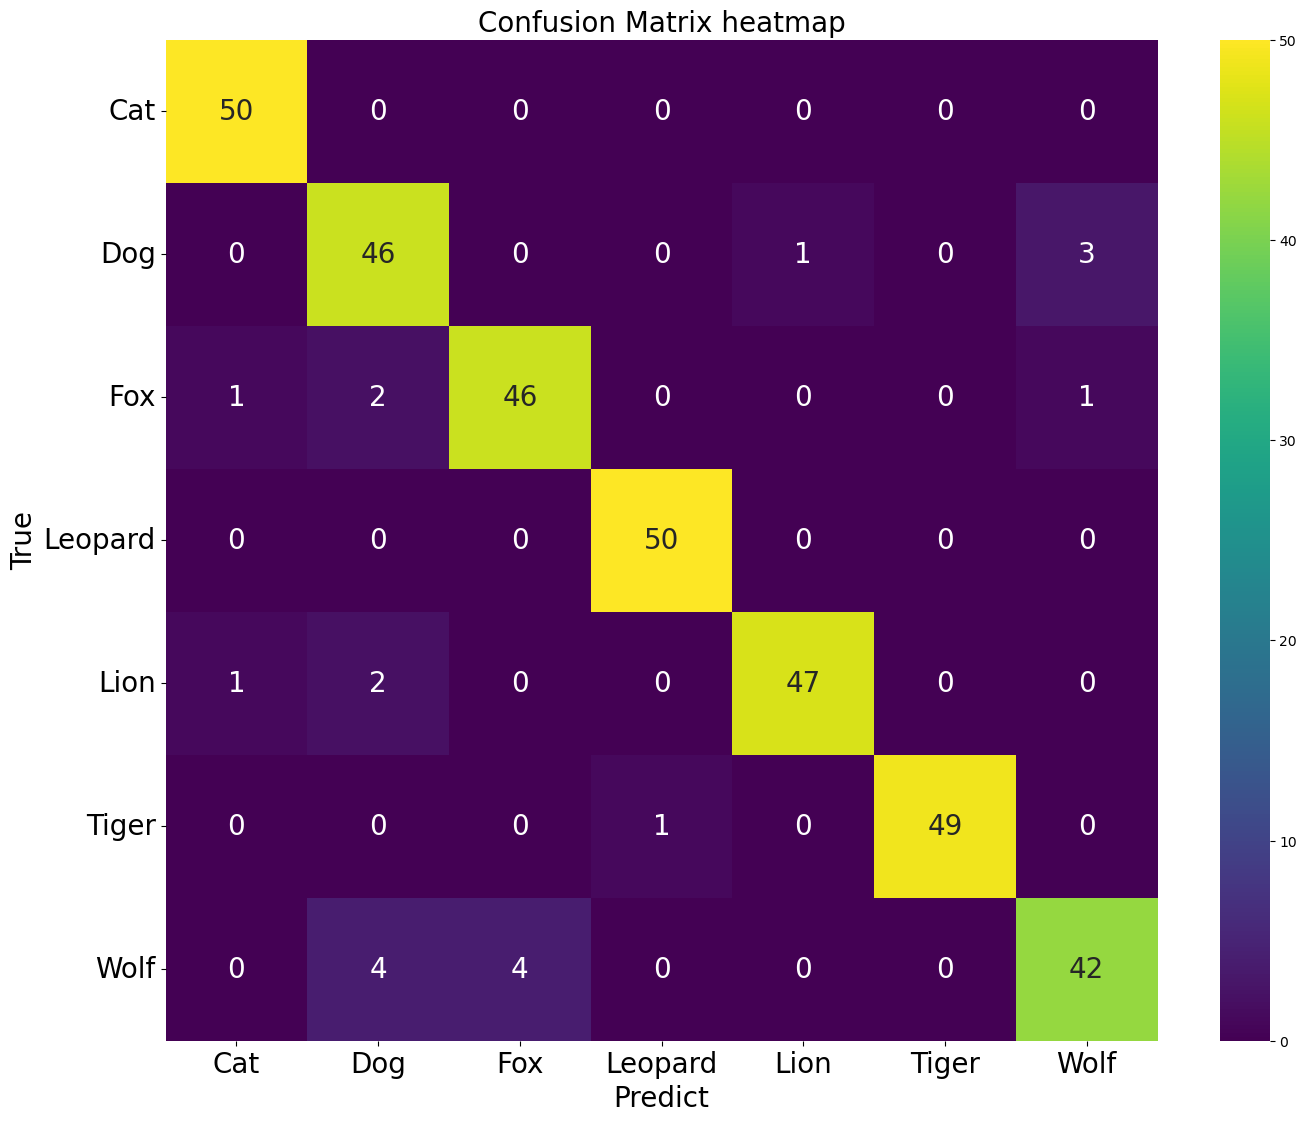

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
訓練集各類別樣本數:
 3    5501
0    5072
1    4693
4    4385
6    3673
5    3670
2    3524
Name: count, dtype: int64


In [22]:
# 貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
heatmap_label=["Cat","Dog","Fox","Leopard","Lion","Tiger","Wolf"]
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 20, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True",fontsize=20)
heatmap.set_xticklabels(heatmap_label, fontsize=20)
plt.xlabel("Predict",fontsize=20)
heatmap.set_yticklabels(heatmap_label, rotation=0, fontsize=20)
plt.title("Confusion Matrix heatmap",fontsize=20)
plt.show()
print("貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6\n訓練集各類別樣本數:\n",pd.Series(np.argmax(train_label, axis=1)).value_counts())